In [334]:
from time import sleep
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import math
import random

from pettingzoo.classic import connect_four_v3

import pygame

In [335]:
# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [336]:
#env = connect_four_v3.env(render_mode="human")
env = connect_four_v3.env()
env.reset()

In [337]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 0.001
TAU = 0.005
LR = 1e-4

In [338]:
# Get number of actions from gym action space
n_actions = 7

# Get the number of state observations
observation, reward, termination, truncation, info = env.last()

#observation_shape = np.array(observation["observation"]).reshape(1,-1)
n_observations = 84



In [339]:
class ActorNetwork(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(ActorNetwork, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [340]:
class CriticNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(CriticNetwork, self).__init__()
        self.linear1 = nn.Linear(state_size, 128)
        self.linear2 = nn.Linear(128, 128)
        self.linear3 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return self.linear3(x)

In [341]:
class SAC:
    def __init__(self,lr,batch_size,gamma,tau, eps_start,eps_end,eps_dec, n_observations,n_actions):
        
        self.lr = lr
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.epsilon = eps_start
        self.eps_end = eps_end
        self.eps_dec = eps_dec
        
        self.n_observations = n_observations
        self.n_actions = n_actions

        self.policy_net = ActorNetwork(n_observations, n_actions).to(device)
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=LR, amsgrad=True)

        self.critic_net_1 = CriticNetwork(n_observations, n_actions).to(device)
        self.critic_optimizer_1 = optim.Adam(self.critic_net_1.parameters(), lr=LR, amsgrad=True)
        self.critic_net_2 = CriticNetwork(n_observations, n_actions).to(device)
        self.critic_optimizer_2 = optim.Adam(self.critic_net_2.parameters(), lr=LR, amsgrad=True)

        self.target_net_1 = CriticNetwork(n_observations, n_actions).to(device)
        self.target_optimizer_1 = optim.Adam(self.target_net_1.parameters(), lr=LR, amsgrad=True)
        self.target_net_2 = CriticNetwork(n_observations, n_actions).to(device)
        self.target_optimizer_2 = optim.Adam(self.target_net_2.parameters(), lr=LR, amsgrad=True)


        self.memory = []

        self.criterion_1 = nn.MSELoss()
        self.criterion_2 = nn.MSELoss()
        self.probs = []
        self.loss = 0




    def choose_action(self, agent, state):
        if np.random.random() < self.epsilon:
            action = env.action_space(agent).sample(state["action_mask"])
        else:
            action_mask = torch.tensor(state["action_mask"])
            state_tensor = torch.FloatTensor(np.array(state["observation"]).reshape(1,-1))
            
            q_values = self.policy_net(state_tensor)
            max, min= torch.max(q_values), torch.min(q_values)
            q_values = (q_values-min)/ (max-min)
            valid_actions = action_mask *  q_values

            #print(valid_actions)

            #self.probs = valid_actions

            action = np.argmax(valid_actions.detach().numpy())


            self.policy_net.train()
            self.decrement_epsilon()

        return action
    
    def update(self, state, new_state, reward,done):
        
        
        
        state_tensor = torch.FloatTensor(np.array(state["observation"]).reshape(1,-1))
        new_state_tensor = torch.FloatTensor(np.array(new_state["observation"]).reshape(1,-1))

        next_action_prob = self.policy_net(state_tensor)


        next_q_target_1 = self.target_net_1(new_state_tensor)
        next_q_target_2 = self.target_net_2(new_state_tensor)

        min_next_q_target = torch.min(next_q_target_1, next_q_target_2)
        next_q = (10 * reward) + (1 - done) * self.gamma * (min_next_q_target - next_action_prob)

        Value_1 = self.critic_net_1(state_tensor)
        value_2 = self.critic_net_2(state_tensor)

        loss_1 = self.criterion_1(Value_1,next_q)
        loss_2 = self.criterion_2(value_2,next_q)

        self.loss = (loss_1 + loss_2)/2

        self.policy_optimizer.zero_grad()
        self.critic_optimizer_1.zero_grad()
        self.critic_optimizer_2.zero_grad()
        self.target_optimizer_1.zero_grad()
        self.target_optimizer_2.zero_grad()

        self.loss.backward()
        
        self.policy_optimizer.step()
        self.critic_optimizer_1.step()
        self.critic_optimizer_2.step()
        self.target_optimizer_1.step()
        self.target_optimizer_2.step()




    def update_memory(self,state, reward, termination, truncation, info):
        self.memory.append((state, reward, termination, truncation, info))

    def clear_memory(self):
        self.memory = []


    def optimize(self):
        self.policy_optimizer.zero_grad()
        self.critic_optimizer_1.zero_grad()
        self.critic_optimizer_2.zero_grad()
        self.target_optimizer_1.zero_grad()
        self.target_optimizer_2.zero_grad()
        
        self.policy_optimizer.step()
        self.critic_optimizer_1.step()
        self.critic_optimizer_2.step()
        self.target_optimizer_1.step()
        self.target_optimizer_2.step()
    
    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
            if self.epsilon > self.eps_end else self.eps_end
    


In [342]:
"""
def update(batch_size,gamma=0.99,soft_tau=1e-2,):
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    predicted_q_value1 = soft_q_net1(state, action)
    predicted_q_value2 = soft_q_net2(state, action)
    predicted_value    = value_net(state)
    new_action, log_prob, epsilon, mean, log_std = policy_net.evaluate(state)

# Training Q Function
    target_value = target_value_net(next_state)
    target_q_value = reward + (1 - done) * gamma * target_value
    q_value_loss1 = soft_q_criterion1(predicted_q_value1, target_q_value.detach())
    q_value_loss2 = soft_q_criterion2(predicted_q_value2, target_q_value.detach())
    print("Q Loss")
    print(q_value_loss1)
    soft_q_optimizer1.zero_grad()
    q_value_loss1.backward()
    soft_q_optimizer1.step()
    soft_q_optimizer2.zero_grad()
    q_value_loss2.backward()
    soft_q_optimizer2.step()    
# Training Value Function
    predicted_new_q_value = torch.min(soft_q_net1(state, new_action),soft_q_net2(state, new_action))
    target_value_func = predicted_new_q_value - log_prob
    value_loss = value_criterion(predicted_value, target_value_func.detach())
    print("V Loss")
    print(value_loss)
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()
# Training Policy Function
    policy_loss = (log_prob - predicted_new_q_value).mean()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    
    
    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - soft_tau) + param.data * soft_tau
        )
"""

'\ndef update(batch_size,gamma=0.99,soft_tau=1e-2,):\n    \n    state, action, reward, next_state, done = replay_buffer.sample(batch_size)\n\n    state      = torch.FloatTensor(state).to(device)\n    next_state = torch.FloatTensor(next_state).to(device)\n    action     = torch.FloatTensor(action).to(device)\n    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)\n    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)\n\n    predicted_q_value1 = soft_q_net1(state, action)\n    predicted_q_value2 = soft_q_net2(state, action)\n    predicted_value    = value_net(state)\n    new_action, log_prob, epsilon, mean, log_std = policy_net.evaluate(state)\n\n# Training Q Function\n    target_value = target_value_net(next_state)\n    target_q_value = reward + (1 - done) * gamma * target_value\n    q_value_loss1 = soft_q_criterion1(predicted_q_value1, target_q_value.detach())\n    q_value_loss2 = soft_q_criterion2(predicted_q_value2, target_q_value.detach())\n    pri

In [343]:
sac_agent = SAC(lr=LR,gamma=GAMMA,batch_size=BATCH_SIZE,tau=TAU,
                eps_start=EPS_START,eps_end=EPS_END,eps_dec=EPS_DECAY,
                n_observations=n_observations,n_actions=n_actions)


In [344]:
# Inicializa pygame
#pygame.init()

# Crea la ventana
#screen = pygame.display.set_mode ( (400,400),pygame.RESIZABLE )
#pygame.VIDEORESIZE

agent_score = []

num_episodes = 1000
total_reward_player_0 = 0
total_reward_player_1 = 0
last_action_player_1 = 0
previous_state = observation

for episode in range(num_episodes):


    state = env.reset()
    #env.render()
    


    for agent in env.agent_iter():
        #print(agent)
        state, reward, termination, truncation, info = env.last()
        #sac_agent.update_memory(state, reward, termination, truncation, info)


        if termination or truncation:
                #print(env.rewards)
                total_reward_player_0 = total_reward_player_0 + env.rewards["player_0"]
                total_reward_player_1 = total_reward_player_1 + env.rewards["player_1"]
                #sac_agent.optimize()
                agent_score.append(total_reward_player_1)
                #sac_agent.clear_memory()
                #sac_agent.learn(previous_state,last_action_player_1,total_reward_player_1,state)

                break
        
        if(agent == "player_0"):
            #print("Player 1")

            mask = state["action_mask"]
            action = env.action_space(agent).sample(mask)  # this is where you would insert your policy
            #print(action)
            env.step(action)
        else:
            #print("Player 2")
            
            mask = state["action_mask"]
            #action = env.action_space(agent).sample(mask)  # this is where you would insert your policy
            action= sac_agent.choose_action(agent,state)

            #state_tensor = torch.FloatTensor(np.array(state["observation"]).reshape(1,-1))

            #action = policy_net.act(state_tensor)
            #print(action)
            #print(action)
            #action = int(input("Elige la columna: \n")) - 1 
            env.step(action) 

            new_state, new_reward, new_termination, new_truncation, new_info = env.last()
            sac_agent.update(state,new_state,new_reward,new_termination)
            


            last_action_player_1 = action 
        previous_state = state["observation"]
    env.close()

print("Total score player 1: " + str(total_reward_player_0))
print("Total score player 2: " + str(total_reward_player_1))


[WARNING]: Illegal move made, game terminating with current player losing. 
obs['action_mask'] contains a mask of all legal moves that can be chosen.
Total score player 1: -286
Total score player 2: 285.0


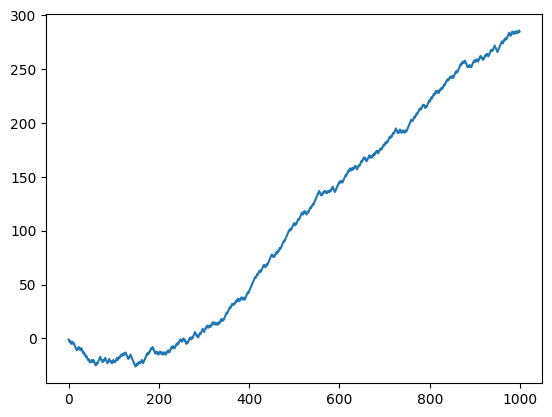

In [345]:
plt.plot(agent_score)
plt.show()

In [346]:
"""
Referencias:

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

"""

'\nReferencias:\n\nhttps://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html\n\n'